In [1]:
import cv2
import os
import numpy as np
from skimage import data,filters
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 设置正常显示负号

In [2]:
root_2 = 'train_2'
img_names = os.listdir(root_2)
img_names = sorted(img_names,key = lambda name : int(name.split('-')[0])) # 按顺序读取图片

In [3]:
def seg_mode(img=None, img_name=None):
    if img is not None:# 待设计识别模式
        pass
    elif img_name is not None:
        if img_name.split('.')[-1] == 'jpg':
            return 'center'
        else:
            return 'all'
        
# https://blog.csdn.net/weixin_42009479/article/details/105812705
import cv2
import numpy as np
from scipy.signal import lfilter

N = 5000
b = 0.5

def max_min_value_filter(image, ksize=3, mode=1):# 最小值滤波的卷积核
    img = image.copy()
    rows, cols = img.shape
    padding = (ksize-1) // 2
    new_img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=1)
    for i in range(rows):
        for j in range(cols):
            roi_img = new_img[i:i+ksize, j:j+ksize].copy()
            min_val, max_val, min_index, max_index = cv2.minMaxLoc(roi_img)
            if mode == 1:
                img[i, j] = max_val
            elif mode == 2:
                img[i, j] = min_val
            else:
                raise Exception("please Select a Mode: max(1) or min(2)")

    return img


def movingthreshold(f, n, k):
    shape = f.shape
    assert n >= 1
    assert 0 < k < 1
    f[1:-1:2, :] = np.fliplr(f[1:-1:2, :])
    f = f.flatten()
    maf = np.ones(n) / n
    res_filter = lfilter(maf, 1, f)
    g = np.array(f > k * res_filter).astype(int)
    g = g.reshape(shape)
    g[1:-1:2, :] = np.fliplr(g[1:-1:2, :])
    return g

def iter_gauss(img,ksize=55,sigma=35,g_t = 0.3,iter_num = 5):
    for i in range(iter_num):
        img = cv2.GaussianBlur(img,(ksize,ksize),sigma)
        img[img>g_t]=1
    img[img<=g_t] = 0
    return img

def seg_stone(gray):
    # 移动平均阈值

    gray_mt = 1-movingthreshold(gray,1*gray.shape[1],0.4)
    gray_mt = cv2.GaussianBlur(gray_mt.astype(np.float),(5,5),5)
    gray_mt_before = gray_mt.copy()
    gray_mt[:50,60:170][gray_mt[:50,60:170]<gray_mt[gray_mt>0].mean()] = 0
    gray_mt[175:,60:170][gray_mt[175:,60:170]<gray_mt[gray_mt>0].mean()] = 0
    gray_mt = (gray_mt>0.4*gray_mt.mean())*1    
    # 最大滤波
    g_max = max_min_value_filter(gray_mt,3,1)
    g_max = cv2.blur(g_max,(3,3))

    # 形态学闭运算
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))  
    morph_img =cv2.morphologyEx(gray_mt.astype(np.float)
                                ,cv2.MORPH_CLOSE,kernel) 

    # 形态学开运算
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))  
    morph_img =cv2.morphologyEx(morph_img.astype(np.float)
                                ,cv2.MORPH_OPEN,kernel) 
    mask = morph_img
    # 迭代高斯滤波
    mask = iter_gauss(morph_img,ksize = 3,sigma = 1)
    return mask#, gray_mt, gray_mt_before,g_max

In [210]:
from PIL import Image
percs = []
for i in range(len(img_names)):
    
    imgs = os.path.join(root_2,img_names[i])
    segmentation_mode = seg_mode(img_name = imgs)
    img = cv2.imread('./'+imgs )
    if segmentation_mode == 'center':
        img_temp = Image.fromarray(img).resize((224,224))
        img_temp = np.asarray(img_temp)
        # 灰度图
        gray = cv2.cvtColor(img_temp,cv2.COLOR_BGR2GRAY)
        
        mask = seg_stone(gray)
        mask = Image.fromarray(mask).resize(img_backup.shape[:-1][::-1])
        mask = np.array(mask)
        
    elif segmentation_mode == 'all':
        mask = np.ones(img.shape[:-1])
        
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    
    ary = np.asarray(dst_1)
    sum_ary = np.sum(mask)
    sum_1 = np.sum(ary)
    perc = sum_1 / sum_ary

    percs.append(perc)

    print('石头大小：', sum_ary)
    print('求和：', sum_1)
    print('百分比：', perc)

石头大小： 5013504
求和： 2979032.0
百分比： 0.594201580371732
石头大小： 5013504
求和： 2508213.0
百分比： 0.5002914129518995
石头大小： 5013504
求和： 2330794.0
百分比： 0.46490318946589054
石头大小： 5013504
求和： 3232739.0
百分比： 0.6448063071257149
石头大小： 5013504
求和： 3731394.0
百分比： 0.7442686791513481
石头大小： 5013504
求和： 3358713.0
百分比： 0.6699332442938113
石头大小： 5013504
求和： 2554671.0
百分比： 0.5095579857919731
石头大小： 5013504
求和： 2159618.0
百分比： 0.4307602028441585
石头大小： 5013504
求和： 3170650.0
百分比： 0.632421954784518
石头大小： 5013504
求和： 2046105.0
百分比： 0.40811875287224264
石头大小： 5013504
求和： 1768589.0
百分比： 0.352765052147161
石头大小： 5013504
求和： 2291064.0
百分比： 0.45697859221813725
石头大小： 5013504
求和： 2480990.0
百分比： 0.4948614781198938
石头大小： 5013504
求和： 3191858.0
百分比： 0.6366521299274919
石头大小： 5013504
求和： 3518136.0
百分比： 0.7017319623161765
石头大小： 5013504
求和： 2568005.0
百分比： 0.5122176026986316
石头大小： 5013504
求和： 1664822.0
百分比： 0.3320675519556781
石头大小： 5013504
求和： 3657792.0
百分比： 0.7295879289215687
石头大小： 5013504
求和： 3462926.0
百分比： 0.690719704222835
石头大小： 5013504

In [203]:
mask_new = np.zeros((mask_temp.shape[0]+2,mask_temp.shape[1]+2))
mask_new[1:-1,1:-1]=mask_temp
mask_new = cv2.floodFill(mask_new,mask=None)

TypeError: Required argument 'seedPoint' (pos 3) not found

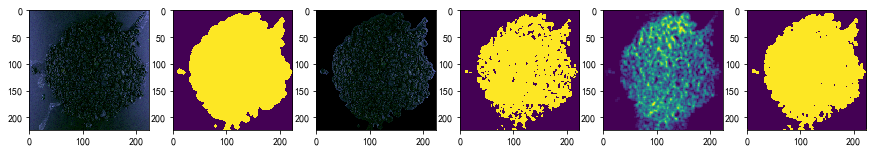

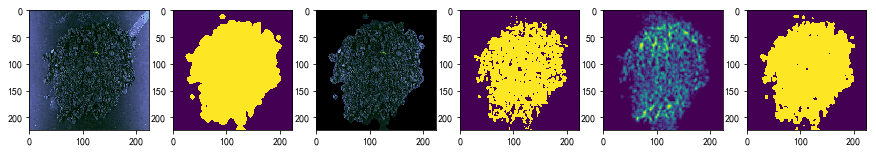

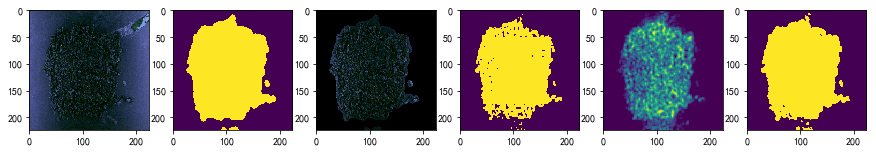

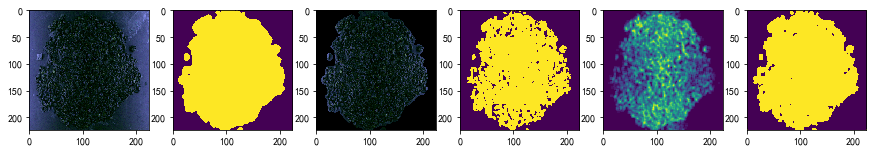

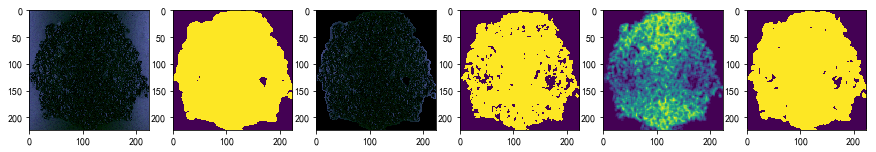

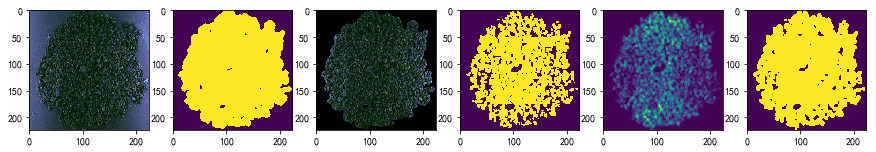

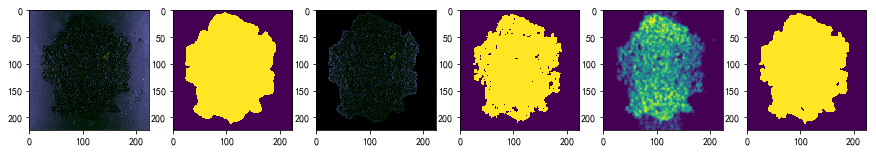

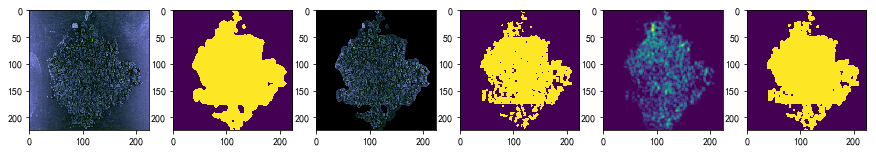

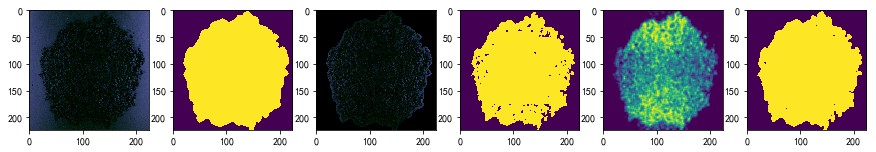

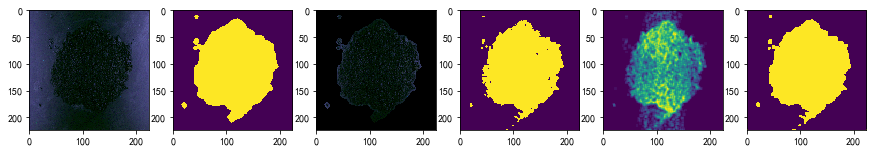

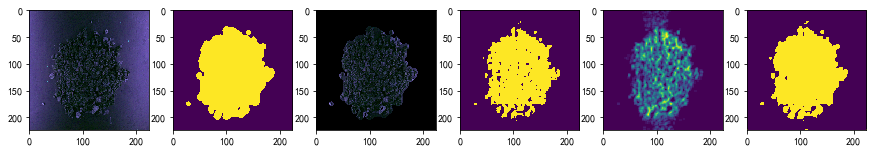

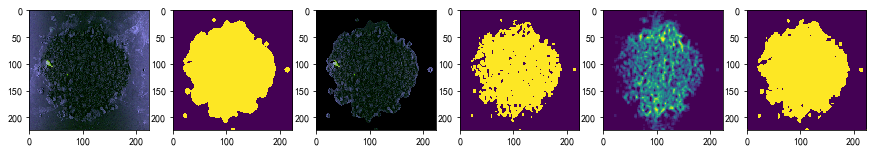

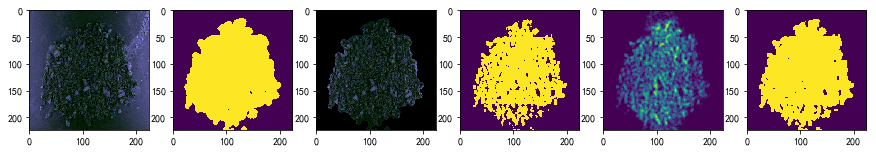

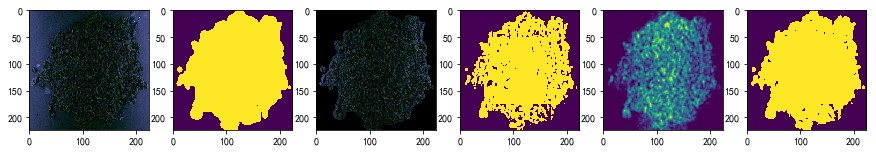

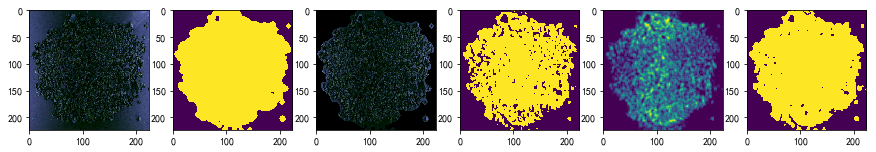

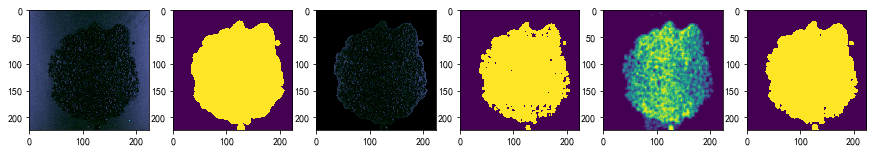

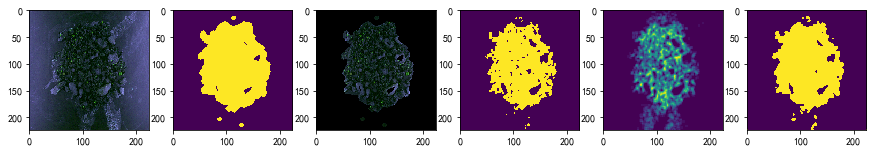

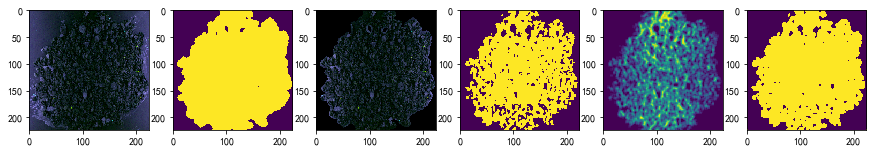

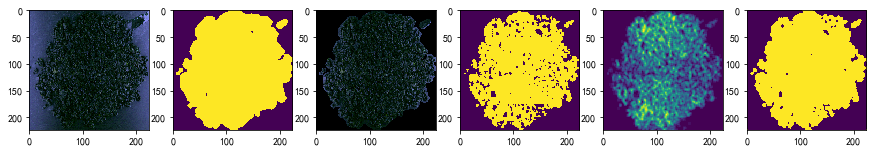

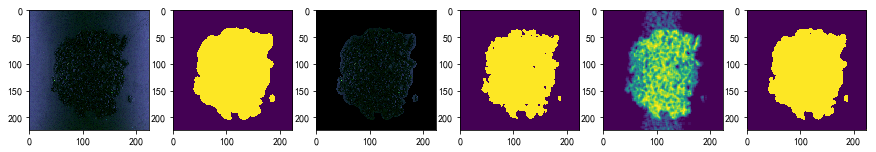

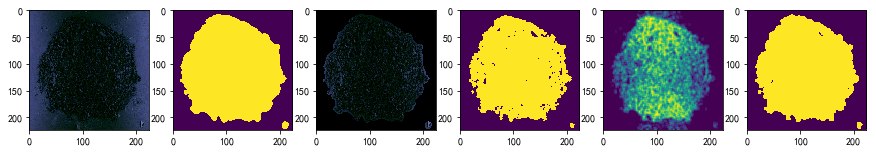

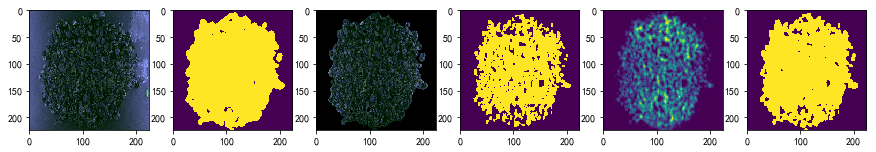

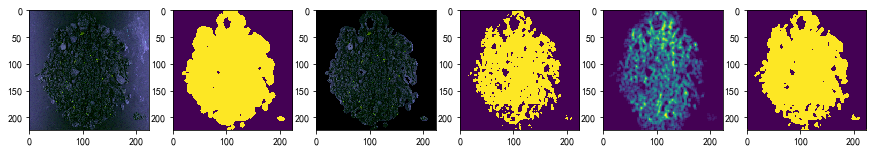

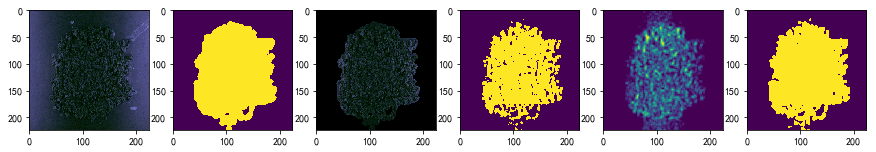

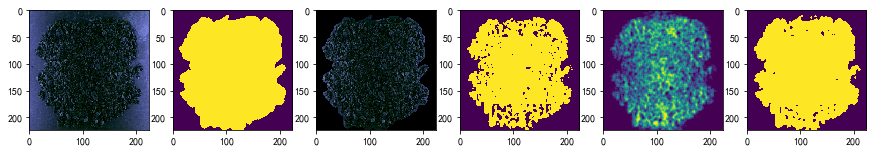

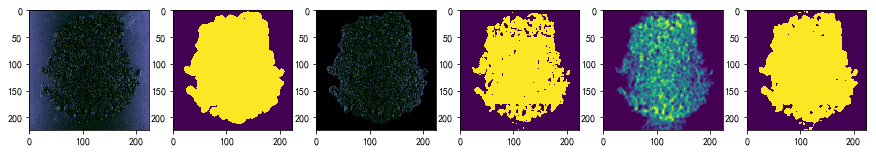

In [193]:
from PIL import Image
percs = []
for i in range(len(img_names)):
    
    imgs = os.path.join(root_2,img_names[i])
    segmentation_mode = seg_mode(img_name = imgs)
    if segmentation_mode == 'all':
        continue
    img = cv2.imread('./'+imgs )
    if segmentation_mode=='all':
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        thresh = filters.threshold_otsu(img)   #返回一个阈值
        dst =(gray >= thresh)*1.0   #根据阈值进行分割

        thresh_1 = 60   #设定一个阈值
        dst_1 =(gray >= thresh_1)*1.0   #根据阈值进行分割

        plt.figure('thresh',figsize=(25, 5))

        plt.subplot(131)
        plt.title(img_names[i])
        plt.imshow(img, plt.cm.gray)

        plt.subplot(132)
        plt.title('设定阈值：'+ str(thresh_1))
        plt.imshow(dst_1, plt.cm.gray)

        plt.subplot(133)
        plt.title('自动阈值')
        plt.imshow(dst,plt.cm.gray)
        plt.show()

        ary = np.asarray(dst_1)
        sum_ary = ary.size
        sum_1 = np.sum(ary)
        perc = sum_1 / sum_ary

        percs.append(perc)

        print('图像大小：', sum_ary)
        print('求和：', sum_1)
        print('百分比：', perc)
    
    elif segmentation_mode == 'center':
        img = Image.fromarray(img).resize((224,224))
        img = np.asarray(img)
        # 灰度图
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        mask,gray_mt,gray_mt_before,g_max = seg_stone(gray)
        # 均值滤波
#         mask_mean = cv2.blur(morph_img,(15,15))
#         mask_mean[mask_mean>0]=1
        
        img_temp = img.copy()
        for i in range(img.shape[-1]):
            img_temp[:,:,i] = img_temp[:,:,i]*mask
        img_temp = cv2.cvtColor(img_temp,cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_temp,cv2.COLOR_BGR2GRAY)

        thresh = filters.threshold_otsu(img)   #返回一个阈值
        dst =(gray >= thresh)*1.0   #根据阈值进行分割

        thresh_1 = 60   #设定一个阈值
        dst_1 =(gray >= thresh_1)*1.0   #根据阈值进行分割
        
        plt.figure(figsize = (15,8))
        plt.subplot(161)
        plt.imshow(img)
        plt.subplot(162)
        plt.imshow(mask)
        plt.subplot(163)
        plt.imshow(img_temp)
        plt.subplot(164)
        plt.imshow(gray_mt)
        plt.subplot(165)
        plt.imshow(gray_mt_before)
        plt.subplot(166)
        plt.imshow(g_max)
        
#         plt.figure('thresh',figsize=(25, 5))

#         plt.subplot(131)
#         plt.title(img_names[i])
#         plt.imshow(img, plt.cm.gray)

#         plt.subplot(132)
#         plt.title('设定阈值：'+ str(thresh_1))
#         plt.imshow(dst_1, plt.cm.gray)

#         plt.subplot(133)
#         plt.title('自动阈值')
#         plt.imshow(dst,plt.cm.gray)
        plt.show()



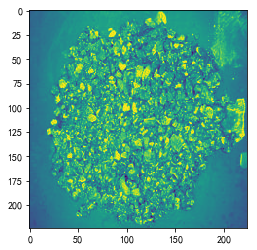

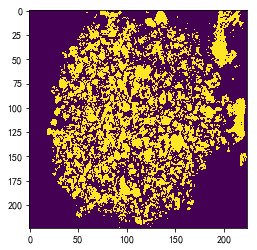

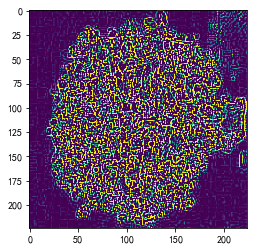

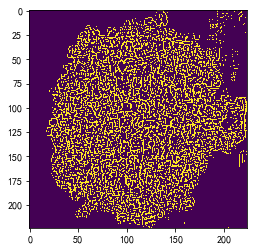

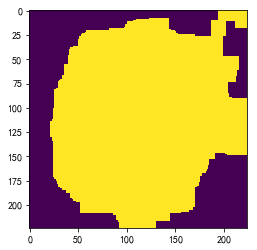

In [112]:
img_name = 'train_1/350-1.jpg'
img = plt.imread(img_name)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
thresh = filters.threshold_otsu(img) 
mask = (gray>=thresh)*1

dst = cv2.Laplacian(gray,-1,ksize = 3)#,scale = 200)
# dst = (dst-dst.min())*255/(dst.max()-dst.min())
thresh = filters.threshold_otsu(dst) 
dst_mask = (dst>=thresh)*1

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))  
morph_img =cv2.morphologyEx(dst_mask.astype(np.float)
                                    ,cv2.MORPH_CLOSE,kernel) 

# 形态学开运算
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))  
morph_img =cv2.morphologyEx(morph_img.astype(np.float)
                            ,cv2.MORPH_OPEN,kernel) 

plt.imshow(gray)
plt.figure()
plt.imshow(mask)
plt.figure()
plt.imshow(dst)
plt.figure()
plt.imshow(dst_mask)
plt.figure()
plt.imshow(morph_img)
plt.show()

In [46]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(100,100))  
morph_img =cv2.morphologyEx(dst_1,cv2.MORPH_CLOSE,kernel)  

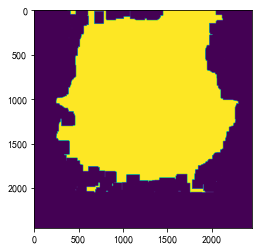

In [47]:
plt.imshow(morph_img)
plt.show()

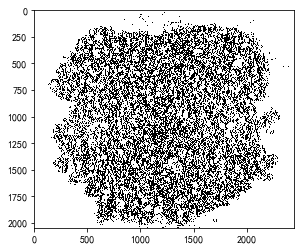

In [4]:
# https://blog.csdn.net/weixin_42009479/article/details/105812705
import cv2
import numpy as np
from scipy.signal import lfilter

N = 10
b = 0.5

def max_min_value_filter(image, ksize=3, mode=1):# 最小值滤波的卷积核
    img = image.copy()
    rows, cols = img.shape
    # if channels == 3:
    #     img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    padding = (ksize-1) // 2
    new_img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=255)
    for i in range(rows):
        for j in range(cols):
            roi_img = new_img[i:i+ksize, j:j+ksize].copy()
            min_val, max_val, min_index, max_index = cv2.minMaxLoc(roi_img)
            if mode == 1:
                img[i, j] = max_val
            elif mode == 2:
                img[i, j] = min_val
            else:
                raise Exception("please Select a Mode: max(1) or min(2)")

    return img


def movingthreshold(f, n, k):
    shape = f.shape
    assert n >= 1
    assert 0 < k < 1
    f[1:-1:2, :] = np.fliplr(f[1:-1:2, :])
    f = f.flatten()
    maf = np.ones(n) / n
    res_filter = lfilter(maf, 1, f)
    g = np.array(f > k * res_filter).astype(int)
    g = g.reshape(shape)
    g[1:-1:2, :] = np.fliplr(g[1:-1:2, :])
    g = g * 255

#     max value filter
    g = max_min_value_filter(g, 3, 2)
    cv2.blur(g, (3, 3))

    return g


img = cv2.imread('./train_2/349-2.jpg', 0)
res = movingthreshold(img, N, b)
plt.imshow(res,plt.cm.gray)

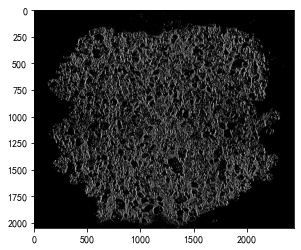

In [61]:
thresh = filters.threshold_otsu(res)
res_otsu = (res<=thresh)*1
res_otsu.astype(np.uint8)
plt.imshow(res_otsu,plt.cm.gray)
plt.show()

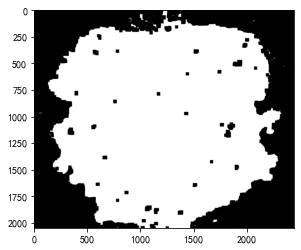

In [78]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))  
morph_img =cv2.morphologyEx(res_otsu.astype(np.float)
                            ,cv2.MORPH_CLOSE,kernel) 
plt.imshow(morph_img,plt.cm.gray)
plt.show()

# 整理
由于亮度不统一，还是大津法等自动分割算法会更好些

之前可能做一个高斯滤波也比较不错

判断中心是0多还是1多，按百分比裁切

In [10]:
# https://blog.csdn.net/weixin_42009479/article/details/105812705
import cv2
import numpy as np
from scipy.signal import lfilter

N = 10
b = 0.5

def max_min_value_filter(image, ksize=20, mode=1):# 最小值滤波的卷积核
    img = image.copy()
    rows, cols = img.shape
    # if channels == 3:
    #     img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    padding = (ksize-1) // 2
    new_img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=1)
    for i in range(rows):
        for j in range(cols):
            roi_img = new_img[i:i+ksize, j:j+ksize].copy()
            min_val, max_val, min_index, max_index = cv2.minMaxLoc(roi_img)
            if mode == 1:
                img[i, j] = max_val
            elif mode == 2:
                img[i, j] = min_val
            else:
                raise Exception("please Select a Mode: max(1) or min(2)")

    return img


def movingthreshold(f, n, k):
    shape = f.shape
    assert n >= 1
    assert 0 < k < 1
    f[1:-1:2, :] = np.fliplr(f[1:-1:2, :])
    f = f.flatten()
    maf = np.ones(n) / n
    res_filter = lfilter(maf, 1, f)
    g = np.array(f > k * res_filter).astype(int)
    g = g.reshape(shape)
    g[1:-1:2, :] = np.fliplr(g[1:-1:2, :])
#     g = g * 255

#     max value filter
#     g = max_min_value_filter(g, 3, 2)
#     cv2.blur(g, (3, 3))

    return g

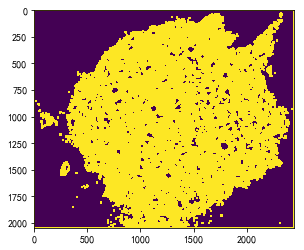

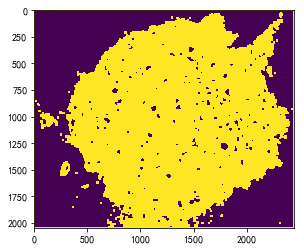

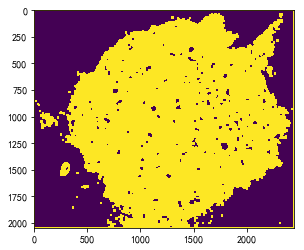

In [18]:
img_path = 'train_2/322-2.jpg'
img = cv2.imread(img_path)

# 灰度图
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# 移动平均阈值
gray_mt = 1-movingthreshold(gray,5,0.5)

# 最大滤波
g_max = max_min_value_filter(gray_mt,20,1)
cv2.blur(g_max,(20,20))
plt.figure()
plt.imshow(g_max)

# 形态学闭运算
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))  
morph_img =cv2.morphologyEx(g_max.astype(np.float)
                            ,cv2.MORPH_CLOSE,kernel) 
plt.figure()
plt.imshow(morph_img)
plt.show()

# 形态学开运算
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))  
morph_img =cv2.morphologyEx(morph_img.astype(np.float)
                            ,cv2.MORPH_OPEN,kernel) 


plt.figure()
plt.imshow(morph_img)
plt.show()


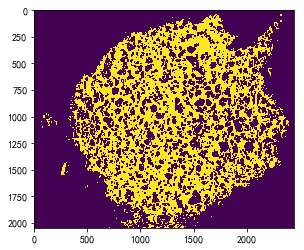

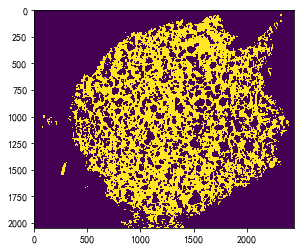

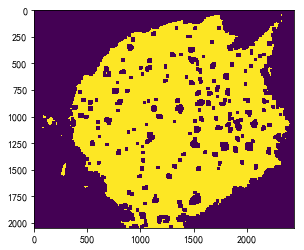

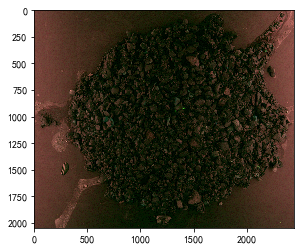

In [108]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))  
morph_img =cv2.morphologyEx(g_max.astype(np.float)
                            ,cv2.MORPH_CLOSE,kernel) 
plt.figure()
plt.imshow(morph_img)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))  
morph_img =cv2.morphologyEx(morph_img.astype(np.float)
                            ,cv2.MORPH_OPEN,kernel) 
plt.figure()
plt.imshow(morph_img)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))  
morph_img =cv2.morphologyEx(morph_img.astype(np.float)
                            ,cv2.MORPH_CLOSE,kernel) 

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))  
morph_img =cv2.morphologyEx(morph_img.astype(np.float)
                            ,cv2.MORPH_CLOSE,kernel) 
plt.figure()
plt.imshow(morph_img)
plt.show()


plt.figure()
plt.imshow(img)
plt.show()



In [ ]:
img_gauss = cv2.(morph_img,(ksize,ksize),sigma)
img_gauss[img_gauss>g_t]=1

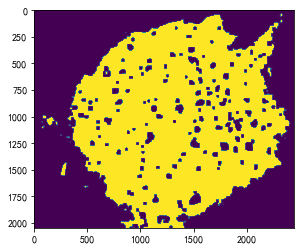

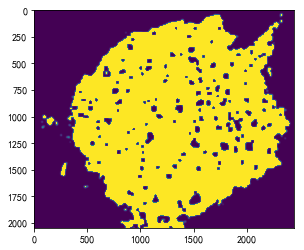

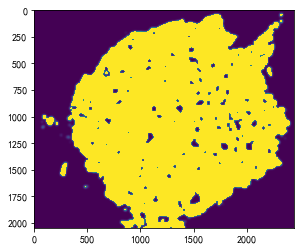

In [125]:
g_t = 0.5
ksize = 55
sigma = 5
img_gauss = cv2.GaussianBlur(morph_img,(ksize,ksize),sigma)
img_gauss[img_gauss>g_t]=1
plt.figure()
plt.imshow(img_gauss)
img_gauss = cv2.GaussianBlur(img_gauss,(ksize,ksize),sigma)
img_gauss[img_gauss>g_t]=1
plt.figure()
plt.imshow(img_gauss)
img_gauss = cv2.GaussianBlur(img_gauss,(ksize,ksize),sigma)
img_gauss[img_gauss>g_t]=1
img_gauss = cv2.GaussianBlur(img_gauss,(ksize,ksize),sigma)
img_gauss[img_gauss>g_t]=1
img_gauss = cv2.GaussianBlur(img_gauss,(ksize,ksize),sigma)
img_gauss[img_gauss>g_t]=1
plt.figure()
plt.imshow(img_gauss)
plt.show()

In [163]:
center = 
morph_fill = cv2.floodFill(img_gauss.copy().astype(np.uint8),mask = None,seedPoint = (1500,150), newVal=(1))

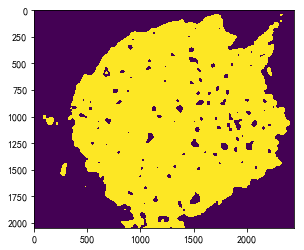

In [164]:
plt.imshow(np.asarray(morph_fill[1]))
plt.show()

In [156]:
morph_fill

(2775943, array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), None, (316, 38, 2095, 2010))